In [1]:
from typing import List,TypedDict

from langchain_community.document_loaders import PyPDFLoader,PyPDFDirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import  RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel

from langgraph.graph import START,StateGraph,END
from dotenv import load_dotenv
import os
import re


d:\Vaibhav_PC\GenerativeAI\GI\Advance_RAG\Campus_RAG\CRAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")
os.environ["OPENROUTER_API_KEY"]=OPENROUTER_API_KEY

In [3]:
model= ChatOpenAI( base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    model= "openrouter/aurora-alpha"
)
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 5, 'total_tokens': 14, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'video_tokens': 0}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': None, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'openrouter/aurora-alpha', 'system_fingerprint': None, 'id': 'chatcmpl-76f046f7401d50e052402456', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c497b-b0ce-7d82-8a98-0c28b8e1adf4-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 5, 'output_tokens': 9, 'total_tokens': 14, 'input_token_details': {'audio': 0, 'cache_rea

In [4]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load()
    + PyPDFLoader("./documents/book2.pdf").load()
    + PyPDFLoader("./documents/book3.pdf").load()
)

In [5]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [6]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)


In [7]:
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [8]:
UPPER_TH = 0.7
LOWER_TH = 0.3

In [9]:
class State(TypedDict):
    question: str
    docs: List[Document]
    
    good_docs: List[Document]
    verdict: str
    reason: str

    strips: List[str]            # output of decomposition (sentence strips)
    kept_strips: List[str]       # after filtering (kept sentences)
    refined_context: str         # recomposed internal knowledge (joined kept_strips)

    answer: str

In [10]:

def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [11]:
# -----------------------------
# Score-based doc evaluator
# -----------------------------
class DocEvalScore(BaseModel):
    score: float
    reason: str

doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict retrieval evaluator for RAG.\n"
            "You will be given ONE retrieved chunk and a question.\n"
            "Return a relevance score in [0.0, 1.0].\n"
            "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
            "- 0.0: chunk is irrelevant\n"
            "Be conservative with high scores.\n"
            "Also return a short reason.\n"
            "Output JSON only.",
        ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}"),
    ]
)

doc_eval_chain = doc_eval_prompt | model.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [12]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | model.with_structured_output(KeepOrDrop)

# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:
    q = state["question"]

    # Combine retrieved docs into one context string
    # 5) In CORRECT case, eval node populates good_docs with docs having score > LOWER_TH
    context = "\n\n".join(d.page_content for d in state["good_docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)

    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [18]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided context.\n"
            "If the context is empty or insufficient, say: 'I don't know.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | model).invoke(
        {"question": state["question"], "refined_context": state["refined_context"]}
    )
    return {"answer": out.content}

In [14]:
def fail_node(state: State) -> State:
    return {"answer": f"FAIL: {state['reason']}"}

def ambiguous_node(state: State) -> State:
    return {"answer": f"Ambiguous: {state['reason']}"}

def route_after_eval(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refine"
    elif state["verdict"] == "INCORRECT":
        return "web_search"
    else:
        return "ambiguous"

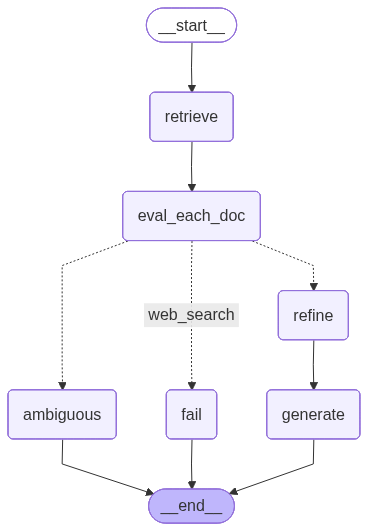

In [19]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("eval_each_doc", eval_each_doc_node)
g.add_node("refine", refine)
g.add_node("generate", generate)
g.add_node("fail", fail_node)
g.add_node("ambiguous", ambiguous_node)


g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {"refine": "refine", "web_search": "fail", "ambiguous": "ambiguous"}
)
g.add_edge("refine", "generate")
g.add_edge("generate", END)
g.add_edge("fail", END)

app = g.compile()
app

In [21]:
res = app.invoke(
    {
        "question": "What are attention mechanisms and why are they important in current models?",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.

OUTPUT:
 I don't know.
